<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-description" data-toc-modified-id="Project-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project description</a></span></li><li><span><a href="#Data-description" data-toc-modified-id="Data-description-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data description</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Creating-models" data-toc-modified-id="Creating-models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Creating models</a></span><ul class="toc-item"><li><span><a href="#Splitting-dataset-into-train-and-test-sets" data-toc-modified-id="Splitting-dataset-into-train-and-test-sets-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Splitting dataset into train and test sets</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Random Forest</a></span></li></ul></li><li><span><a href="#Analyzing-models" data-toc-modified-id="Analyzing-models-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analyzing models</a></span><ul class="toc-item"><li><span><a href="#Checking-the-best-model-on-the-test-set" data-toc-modified-id="Checking-the-best-model-on-the-test-set-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Checking the best model on the test set</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Predicting car price

## Project description

**Brief information:** a used car sales company is developing an application to quickly determine the market value of a car in order to attract new customers.

**Objective:** develop a model to determine the market value of a car based on historical data about the car's technical characteristics, equipment, and price.

**Tasks:** consider and explore different models (including classical algorithms and the LightGBM model) according to prediction quality, prediction, and learning time.

## Data description

The dataset contains a table with the following columns:

* `DateCrawled` — the date the form was crawled from the database;;
* `VehicleType` — vehicle body type;
* `RegistrationYear` — vehicle registration year;
* `Gearbox` — transmission type;
* `Power` — engine power (h.p.);
* `Model` — vehicle model;
* `Kilometer` — vehicle mileage (km);
* `RegistrationMonth` — vehicle registration month;
* `FuelType` — vehicle fuel type;
* `Brand` — vehicle brand;
* `NotRepaired` — whether the vehicle was under repair or not;
* `DateCreated` — the form creation date;
* `NumberOfPictures` — the number of vehicle photos;
* `PostalCode` — the postal code of the form owner (user);
* `LastSeen` — date of the user's last activity;
* `Price` — vehicle price (euro).

## Data preparation

In [1]:
!pip install -q optuna
!pip install -q phik
!pip install -q lightgbm
!pip install -q catboost
!pip install -q category_encoders

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
import optuna
import phik
import time
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from optuna.samplers import TPESampler
from category_encoders.target_encoder import TargetEncoder

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Let's convert the column names to lowercase for ease of use.

In [5]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 
              'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
               'last_seen']

Let's analyze the date when the form was downloaded from the database and estimate the last day of download. To do this, first convert all columns containing dates to the `datetime` format.

In [6]:
data = data.astype({'date_crawled' : 'datetime64[ns]',
                   'date_created' : 'datetime64[ns]',
                   'last_seen' : 'datetime64[ns]'})

In [7]:
data['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

The last day of the download is April 07, 2016. Therefore, cars registered after than this date should be excluded from the dataset.

Next, when building the model, we will work with the feature "age of the car" in years at the time of creating the form (we will replace the column with the year of its registration). For this, we subtract the car registration year from the form creation year. The obtained negative values will further filter the dataset according to the date of unloading the forms.

In [8]:
data['car_age'] = data['date_created'].dt.year - data['registration_year']

Possibly, the price of a car can be influenced by the duration of its sale. Let's create a new feature and calculate the date difference between the creation of the form and the date of the user's last activity.

In [9]:
data['sell_length'] = (data['last_seen'] - data['date_created']).dt.days

Due to the logic of the car pricing process, there are columns in the data set that have no relation to the process:
* `date_crawled` — the date the form was crawled from the database;
* `registration_month` — month of vehicle registration;
* `number_of_pictures` — number of vehicle photos;
* `postal_code` — postal code of the form owner (user).

and columns after feature engineering:
* `date_created` — the form creation date (instead of this feature we now have the car sale duration);
* `last_seen` — date of the user's last activity (instead of this feature we now have the car sale duration);
* `registration_year` - vehicle registration year (instead of this feature we now have the car age).

Using these columns for model building can lead to its overfitting, and some of the columns are not useful in the case of the information. In this regard, we will remove them from the dataset.

In [10]:
data.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 
           'registration_year'], 
          axis='columns', inplace=True)

In [11]:
data.head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,car_age,sell_length
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,23,14
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,5,14
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,12,22
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15,0
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,8,6


Let's calculate the proportion of missing values in our observations.

In [12]:
data.isna().mean().sort_values(ascending=False)

not_repaired    0.200791
vehicle_type    0.105794
fuel_type       0.092827
gearbox         0.055967
model           0.055606
price           0.000000
power           0.000000
kilometer       0.000000
brand           0.000000
car_age         0.000000
sell_length     0.000000
dtype: float64

There are several columns which contains nans:
* `not_repaired`
* `vehicle_type`
* `fuel_type`
* `gearbox`
* `model`

In [13]:
#rows with nans
data[data.isna().any(axis=1)]

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,car_age,sell_length
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,23,14
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,5,14
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,12,22
8,14500,bus,manual,125,c_max,30000,petrol,ford,NaN,2,0
9,999,small,manual,101,golf,150000,NaN,volkswagen,NaN,18,14
...,...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,manual,55,fabia,150000,petrol,skoda,NaN,12,26
354361,5250,NaN,auto,150,159,150000,NaN,alfa_romeo,no,0,4
354364,0,NaN,manual,0,colt,150000,petrol,mitsubishi,yes,11,0
354365,2200,NaN,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,11,23


In [14]:
#example of different features for the same vehicle model
data[data['model'] == 'golf']

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,car_age,sell_length
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,23,14
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15,0
9,999,small,manual,101,golf,150000,NaN,volkswagen,NaN,18,14
32,245,sedan,NaN,0,golf,150000,petrol,volkswagen,no,22,2
35,350,NaN,manual,75,golf,150000,petrol,volkswagen,no,0,0
...,...,...,...,...,...,...,...,...,...,...,...
354315,1300,convertible,manual,90,golf,150000,petrol,volkswagen,no,18,2
354320,1500,sedan,manual,75,golf,150000,petrol,volkswagen,NaN,17,19
354348,5900,sedan,manual,105,golf,150000,gasoline,volkswagen,no,10,18
354359,7900,sedan,manual,140,golf,150000,gasoline,volkswagen,no,6,5


The lack of information about whether the car has been repaired or not may be because the user who filled out the form did not provide this information or implied that the car had not been repaired.

Other features describing the type of vehicle, fuel type, transmission and model of the car can play an important role in determining the value of the car. It is not possible to fill in this information implicitly because, for example, the same car model can belong to both sedan and golf car types and have a diesel or gasoline engine.

In this context, let's use a category for missing values - "unknown" - and fill in the nans with it. For gradient boosting models, this should not cause any problems. We will also convert the categorical columns to the `category' format.

In [15]:
#filling nans
nas = ['not_repaired', 'vehicle_type', 'fuel_type', 'gearbox', 'model']

for col in nas:
    data[col] = data[col].fillna('unknown')

In [16]:
#converting columns into int type
categorical = list(data.select_dtypes(include=['object']).columns)

for col in categorical:
    data[col] = data[col].astype('category')

In [17]:
#check
data.dtypes

price              int64
vehicle_type    category
gearbox         category
power              int64
model           category
kilometer          int64
fuel_type       category
brand           category
not_repaired    category
car_age            int64
sell_length        int64
dtype: object

Now it's time to check our dataset for explicit duplicates.

In [18]:
print(f'Number of duplicates: {data.duplicated().sum()}')

Number of duplicates: 14862


In [19]:
data.drop_duplicates(inplace=True)

### Conclusions

* **During the data preprocessing for the development of the car value prediction model, some of the columns were transformed and two new features were created - the age of the car (years) and the length of its sale (days). It should be noted that the remaining part of the features, in our opinion, does not carry any useful information and may potentially lead to overfitting of the model. These are the columns that primarily characterize the user's activity on the site (date of the form creation, number of vehicle photos, postal code of the form owner, date of the last user activity) and other information (date of the form download from the database, vehicle registration month). These columns have been removed;**
* **Dataset is characterized by missing values in the columns containing information about car repair, vehicle type, fuel type, transmission type and car model. It is not possible to fill the nans by indirect characteristics, because for example the same car model can be characterized by different characteristics (sedans and golf cars, diesel and gasoline engines). In this case, the missing values were filled with an 'unknown' string;**
* **Explicit duplicates have been removed from the dataset to improve model quality. Also, categorical columns and kilometers are converted to `category` format.**

## EDA

We will perform exploratory data analysis to improve the quality of the forecast.

In [20]:
data.describe()

,price,power,kilometer,car_age,sell_length
count,339507.000000,339507.000000,339507.000000,339507.000000,339507.000000
mean,4414.859231,110.266472,128117.844404,11.753065,8.840793
std,4521.113253,192.607962,37974.941958,91.783703,8.662090
min,0.000000,0.000000,5000.000000,-7983.000000,0.000000
25%,1001.000000,69.000000,125000.000000,8.000000,2.000000
50%,2700.000000,105.000000,150000.000000,13.000000,6.000000
75%,6400.000000,141.000000,150000.000000,17.000000,14.000000
max,20000.000000,20000.000000,150000.000000,1016.000000,759.000000


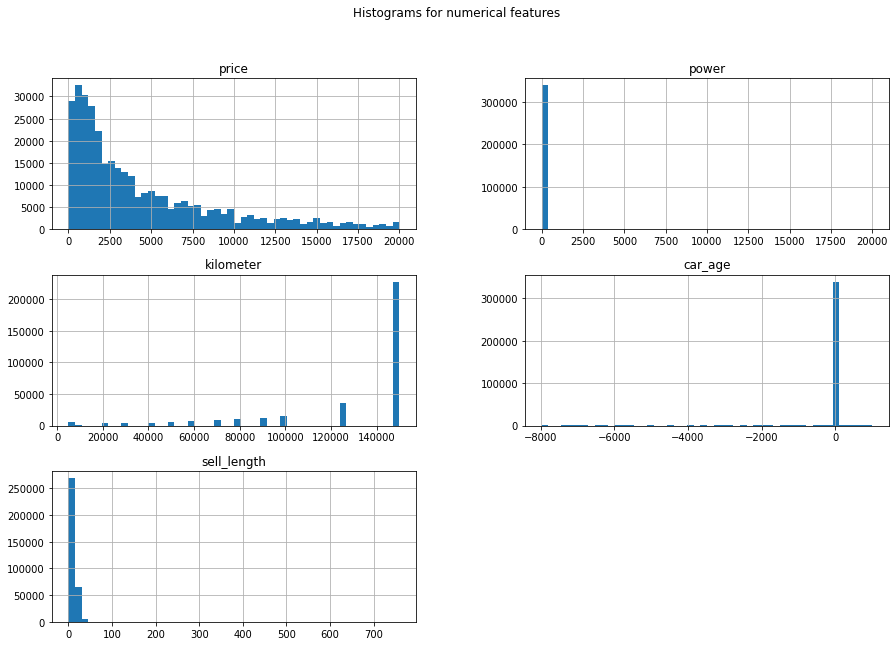

In [21]:
data.hist(bins=50, figsize=(15,10), linewidth=2)
plt.suptitle('Histograms for numerical features');

There are anomalous values in the column with the age of the car, its price and engine power.

For example, the minimum and maximum values for car age are -7893 and 1016, respectively. We'll examine the histogram for this attribute in more detail, limiting the observations to within 100 years.

Zero values for price and engine power may be due to a technical failure to download data from the database or a failure by the user to provide information about the vehicle being sold. The maximum engine power of 20,000 hp also appears to be an anomalous outlier.

Based on the mileage distribution, this column is a category column. Let us bring it into the appropriate format.

In [22]:
data['kilometer'] = data['kilometer'].astype('category')

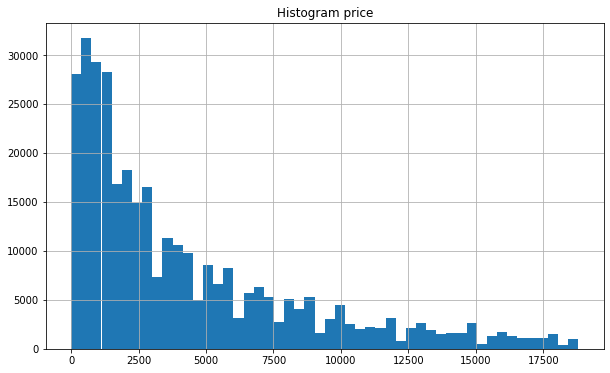

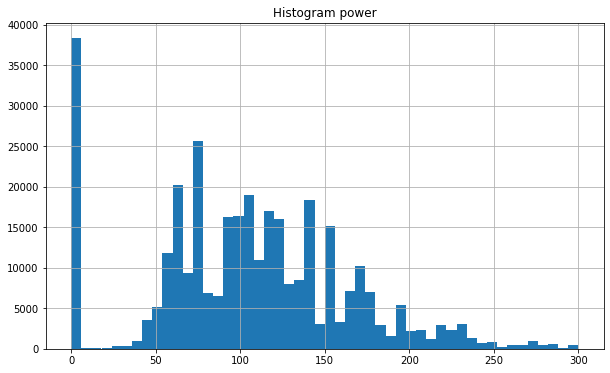

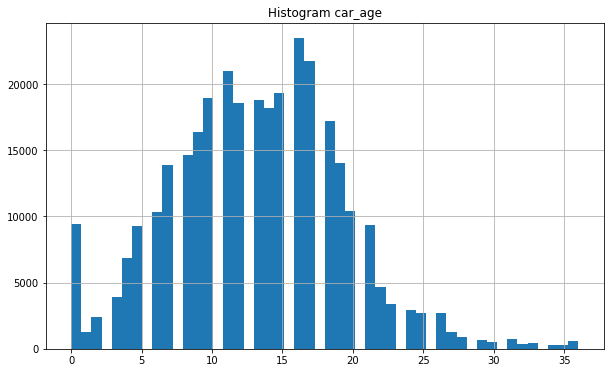

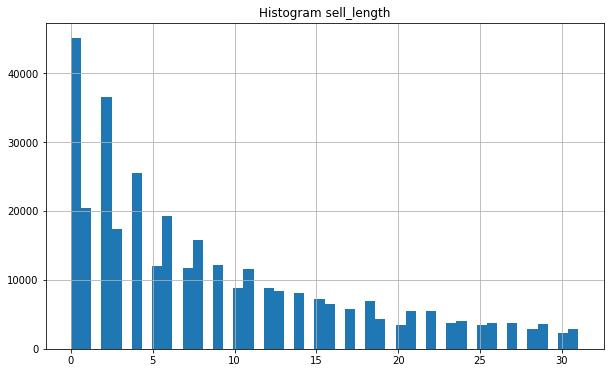

In [23]:
for col in list(data.select_dtypes(include=['number']).columns):
    data[data[col] >= 0][col].hist(bins=50, range=[0,data[col].quantile(0.99)], figsize=(10,6))
    plt.title(f'Histogram {col}')
    plt.show()

So, for the car age, we will remove negative values and values over 35 years from the dataset. 

For the price, we will remove the values equal to 0, while the maximum price can be almost any.

For the engine power, we will remove the values equal to 0 hp and less than 300 hp.

At the same time, the duration of the sale can be any value - the more rare and expensive cars are on sale, the longer they can be sold.

In [24]:
data_cleaned = data.query('(0 <= car_age <= 35) and price > 0 and (0 < power <= 300)')

Let's analyze which features have the most impact on the final cost of a used car.

interval columns not set, guessing: ['price', 'power', 'car_age', 'sell_length']


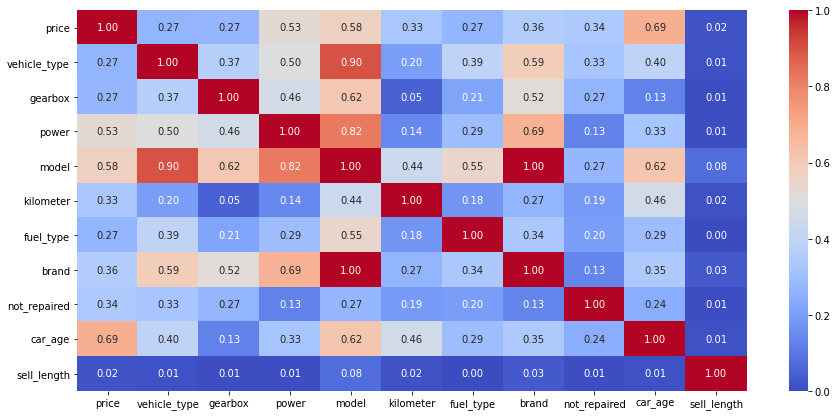

In [25]:
plt.figure(figsize=(15,7))
sns.heatmap(data_cleaned.phik_matrix(), annot=True, fmt='.2f', cmap='coolwarm');

The age of the car has the greatest impact on the value, followed by the model and engine power of the car. The least influence has the duration of the sale. On this basis, we expect that the models will choose these features as the main characteristics.

### Conclusions

* **Anomalous values were observed in the columns with engine power, car age, and price during the EDA.**
* **Analysis of the correlation coefficients (𝜙k) between the features showed that the age of the car (coefficient 0.69), car model (coefficient 0.58), and engine power (0.53) have the greatest influence on the price. The least influence has the duration of sale of the car (coefficient 0.02).**.

## Creating models

### Splitting dataset into train and test sets

In [26]:
features = data_cleaned.drop(['price'], axis = 1)
target = data_cleaned['price']

In [27]:
features_train, features_remaining, target_train, target_remaining = (train_test_split(features, 
                                                                                       target, 
                                                                                       train_size=0.6, 
                                                                                       random_state=42
                                                                                       ))

In [28]:
features_valid, features_test, target_valid, target_test = (train_test_split(features_remaining, 
                                                                             target_remaining, 
                                                                             test_size=0.5, 
                                                                             random_state=42))

### LGBM

In [29]:
#lists for rmse metrics and timings
rmses = []
training_time = []
prediction_time = []
model_name = []

In [30]:
#list with categorical features
features_list = ['vehicle_type', 'gearbox', 'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired']

In [31]:
%%time
#parameters grid function for hyperparamers tuning with optuna
def objective_lgb(trial):
    
    param = { 
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
    }
    model = LGBMRegressor(**param) 

    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    
    rmse = mean_squared_error(target_valid, predictions, squared=False)

    return rmse

sampler = TPESampler(seed=42) #sampler for repeatability
optuna.logging.set_verbosity(optuna.logging.INFO)
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective_lgb, n_trials=30)

#model with the best params
optimised_lgb = LGBMRegressor(max_depth=study_lgb.best_params['max_depth'], num_leaves=study_lgb.best_params['num_leaves'],
                                     learning_rate = study_lgb.best_params['learning_rate'], boosting_type='gbdt', random_state=42, n_jobs=-1, 
                                     objective='regression', metric='rmse')

#training time start
start_lgb_train = time.time()
#fitting
optimised_lgb.fit(features_train, target_train)
#training time end
end_lgb_train = time.time()
#training time as the delta between end and start times
training_lgb = end_lgb_train - start_lgb_train

[I 2023-02-09 18:53:19,432] A new study created in memory with name: no-name-d7ee0a9b-b281-441f-a48a-73d278bc4104
[I 2023-02-09 18:53:19,780] Trial 0 finished with value: 1596.7416007405245 and parameters: {'max_depth': 4, 'num_leaves': 476, 'learning_rate': 0.07587945476302646}. Best is trial 0 with value: 1596.7416007405245.
[I 2023-02-09 18:53:20,363] Trial 1 finished with value: 1709.709997892661 and parameters: {'max_depth': 6, 'num_leaves': 79, 'learning_rate': 0.02403950683025824}. Best is trial 0 with value: 1596.7416007405245.
[I 2023-02-09 18:53:20,586] Trial 2 finished with value: 2437.989691464384 and parameters: {'max_depth': 1, 'num_leaves': 434, 'learning_rate': 0.0641003510568888}. Best is trial 0 with value: 1596.7416007405245.
[I 2023-02-09 18:53:20,911] Trial 3 finished with value: 1577.804116536901 and parameters: {'max_depth': 8, 'num_leaves': 11, 'learning_rate': 0.0972918866945795}. Best is trial 3 with value: 1577.804116536901.
[I 2023-02-09 18:53:21,676] Trial 

CPU times: total: 6min 17s
Wall time: 26.1 s


In [32]:
#best params
study_lgb.best_params

{'max_depth': 10, 'num_leaves': 315, 'learning_rate': 0.09219354899994803}

In [33]:
study_lgb.best_value

1442.2484782586737

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

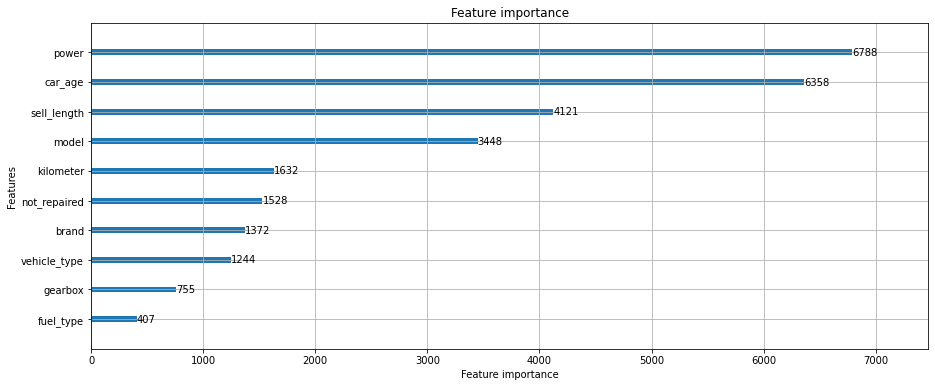

In [34]:
lgb.plot_importance(optimised_lgb, figsize=(15,6))

The analysis of the influence of the features showed that the algorithm identified engine power as the most influential factor. The next most important factor is the age of the car.

In [35]:
#prediction time on the validation set
start_lgb_predict = time.time()
predictions_lgb_valid = optimised_lgb.predict(features_valid)
end_lgb_predict = time.time()
prediction_lgb = end_lgb_predict - start_lgb_predict

In [36]:
#rmse metrics on the validation set
lgb_rmse_valid = mean_squared_error(target_valid, predictions_lgb_valid, squared=False)

In [37]:
#appending lists with rmse and timings
rmses.append(lgb_rmse_valid)
training_time.append(training_lgb)
prediction_time.append(prediction_lgb)
model_name.append(optimised_lgb.__class__.__name__)

### CatBoost

In [38]:
%%time
#parameters grid function for hyperparamers tuning with optuna
def objective_cb(trial):

    param = {
       'loss_function': 'RMSE',
       'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
       'n_estimators': trial.suggest_int( "n_estimators",  40,300,20),
       'max_depth': trial.suggest_int( 'max_depth',  1,8,1),
       'random_seed': 42
       }
    
    model = CatBoostRegressor(**param, cat_features=features_list, verbose=150)  
    
    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    
    rmse = mean_squared_error(target_valid, predictions, squared=False)

    return rmse

sampler = TPESampler(seed=42) #sampler for repeatability
study_cb = optuna.create_study(direction='minimize', sampler=sampler)
study_cb.optimize(objective_cb, n_trials=30)

#model with the best params
optimised_cb = CatBoostRegressor(max_depth=study_cb.best_params['max_depth'], learning_rate=study_cb.best_params['learning_rate'],
                                     n_estimators = study_cb.best_params['n_estimators'], random_seed=42, 
                                     loss_function='RMSE', cat_features=features_list)

#training time start
start_cb_train = time.time()
#fitting
optimised_cb.fit(features_train, target_train)
#training time end
end_cb_train = time.time()
#training time as the delta between end and start times
training_cb = end_cb_train - start_cb_train

[I 2023-02-09 18:53:45,943] A new study created in memory with name: no-name-e4ba2f48-df0f-45c8-b02f-689916ad0337


0:	learn: 4408.3636324	total: 226ms	remaining: 1m 7s
150:	learn: 1676.7324681	total: 13.3s	remaining: 13.1s


[I 2023-02-09 18:54:12,540] Trial 0 finished with value: 1592.1890684688228 and parameters: {'learning_rate': 0.04370861069626263, 'n_estimators': 300, 'max_depth': 6}. Best is trial 0 with value: 1592.1890684688228.


299:	learn: 1586.0937682	total: 26.1s	remaining: 0us
0:	learn: 4393.3889715	total: 17.9ms	remaining: 1.41s


[I 2023-02-09 18:54:14,392] Trial 1 finished with value: 2109.0904801313286 and parameters: {'learning_rate': 0.0638792635777333, 'n_estimators': 80, 'max_depth': 2}. Best is trial 0 with value: 1592.1890684688228.


79:	learn: 2101.1061847	total: 1.67s	remaining: 0us
0:	learn: 4499.0734725	total: 77.9ms	remaining: 21.7s
150:	learn: 2045.2991192	total: 10.8s	remaining: 9.2s


[I 2023-02-09 18:54:34,876] Trial 2 finished with value: 1812.9435212251033 and parameters: {'learning_rate': 0.015227525095137952, 'n_estimators': 280, 'max_depth': 5}. Best is trial 0 with value: 1592.1890684688228.


279:	learn: 1806.6688348	total: 20.2s	remaining: 0us
0:	learn: 4308.3325291	total: 52.7ms	remaining: 2.05s


[I 2023-02-09 18:54:38,165] Trial 3 finished with value: 1808.455091571626 and parameters: {'learning_rate': 0.0737265320016441, 'n_estimators': 40, 'max_depth': 8}. Best is trial 0 with value: 1592.1890684688228.


39:	learn: 1800.8292885	total: 3.07s	remaining: 0us
0:	learn: 4344.9083157	total: 22.3ms	remaining: 1.76s


[I 2023-02-09 18:54:40,506] Trial 4 finished with value: 2020.1156969320937 and parameters: {'learning_rate': 0.08491983767203796, 'n_estimators': 80, 'max_depth': 2}. Best is trial 0 with value: 1592.1890684688228.


79:	learn: 2011.0882500	total: 2.15s	remaining: 0us
0:	learn: 4464.2125411	total: 31.7ms	remaining: 3.77s


[I 2023-02-09 18:54:45,049] Trial 5 finished with value: 1935.7569544926534 and parameters: {'learning_rate': 0.026506405886809047, 'n_estimators': 120, 'max_depth': 5}. Best is trial 0 with value: 1592.1890684688228.


119:	learn: 1928.9028546	total: 4.36s	remaining: 0us
0:	learn: 4397.5460393	total: 45.8ms	remaining: 5.45s


[I 2023-02-09 18:54:49,664] Trial 6 finished with value: 1782.1015860658881 and parameters: {'learning_rate': 0.048875051677790424, 'n_estimators': 120, 'max_depth': 5}. Best is trial 0 with value: 1592.1890684688228.


119:	learn: 1775.8692236	total: 4.42s	remaining: 0us
0:	learn: 4486.0995668	total: 22.8ms	remaining: 2.72s


[I 2023-02-09 18:54:53,501] Trial 7 finished with value: 2237.5452835807646 and parameters: {'learning_rate': 0.022554447458683766, 'n_estimators': 120, 'max_depth': 3}. Best is trial 0 with value: 1592.1890684688228.


119:	learn: 2232.6358108	total: 3.65s	remaining: 0us
0:	learn: 4423.2315958	total: 22.8ms	remaining: 5.45s
150:	learn: 1962.0199926	total: 4.41s	remaining: 2.6s


[I 2023-02-09 18:55:00,792] Trial 8 finished with value: 1871.7749678217947 and parameters: {'learning_rate': 0.05104629857953324, 'n_estimators': 240, 'max_depth': 2}. Best is trial 0 with value: 1592.1890684688228.


239:	learn: 1866.2549531	total: 7.08s	remaining: 0us
0:	learn: 4444.6602454	total: 12.6ms	remaining: 2.5s
150:	learn: 2346.5884051	total: 2.26s	remaining: 734ms


[I 2023-02-09 18:55:03,990] Trial 9 finished with value: 2252.805471115301 and parameters: {'learning_rate': 0.05628109945722505, 'n_estimators': 200, 'max_depth': 1}. Best is trial 0 with value: 1592.1890684688228.


199:	learn: 2245.5404775	total: 3.01s	remaining: 0us
0:	learn: 4420.5439512	total: 105ms	remaining: 31.5s
150:	learn: 1628.6232621	total: 16.8s	remaining: 16.6s
299:	learn: 1533.3957871	total: 33.8s	remaining: 0us


[I 2023-02-09 18:55:38,230] Trial 10 finished with value: 1554.3179146188227 and parameters: {'learning_rate': 0.038021080133309335, 'n_estimators': 300, 'max_depth': 8}. Best is trial 10 with value: 1554.3179146188227.


0:	learn: 4429.5025984	total: 108ms	remaining: 32.2s
150:	learn: 1639.3586910	total: 16.6s	remaining: 16.3s
299:	learn: 1543.9867112	total: 33.4s	remaining: 0us


[I 2023-02-09 18:56:12,059] Trial 11 finished with value: 1560.7649128745313 and parameters: {'learning_rate': 0.03524537807936436, 'n_estimators': 300, 'max_depth': 8}. Best is trial 10 with value: 1554.3179146188227.


0:	learn: 4436.7877392	total: 104ms	remaining: 24.8s
150:	learn: 1649.7747348	total: 16.5s	remaining: 9.73s


[I 2023-02-09 18:56:38,756] Trial 12 finished with value: 1593.9812335358372 and parameters: {'learning_rate': 0.03298991128886791, 'n_estimators': 240, 'max_depth': 8}. Best is trial 10 with value: 1554.3179146188227.


239:	learn: 1581.1305689	total: 26.3s	remaining: 0us
0:	learn: 4419.2783344	total: 122ms	remaining: 31.7s
150:	learn: 1657.6873988	total: 14.4s	remaining: 10.4s


[I 2023-02-09 18:57:04,202] Trial 13 finished with value: 1590.6367378692723 and parameters: {'learning_rate': 0.039368081838051565, 'n_estimators': 260, 'max_depth': 7}. Best is trial 10 with value: 1554.3179146188227.


259:	learn: 1583.0393686	total: 25.1s	remaining: 0us
0:	learn: 4499.8341132	total: 97.6ms	remaining: 19.4s
150:	learn: 1978.9182504	total: 14.5s	remaining: 4.7s


[I 2023-02-09 18:57:23,686] Trial 14 finished with value: 1838.8483188185253 and parameters: {'learning_rate': 0.013865568633649811, 'n_estimators': 200, 'max_depth': 7}. Best is trial 10 with value: 1554.3179146188227.


199:	learn: 1832.8714254	total: 19.2s	remaining: 0us
0:	learn: 4440.6024002	total: 98.7ms	remaining: 29.5s
150:	learn: 1688.9891414	total: 14.9s	remaining: 14.7s


[I 2023-02-09 18:57:53,773] Trial 15 finished with value: 1597.8055602634897 and parameters: {'learning_rate': 0.03259706216081448, 'n_estimators': 300, 'max_depth': 7}. Best is trial 10 with value: 1554.3179146188227.


299:	learn: 1590.1730745	total: 29.7s	remaining: 0us
0:	learn: 4339.5955993	total: 102ms	remaining: 20.4s
150:	learn: 1557.4468005	total: 16.9s	remaining: 5.49s


[I 2023-02-09 18:58:16,957] Trial 16 finished with value: 1549.5090513468567 and parameters: {'learning_rate': 0.0632112627206213, 'n_estimators': 200, 'max_depth': 8}. Best is trial 16 with value: 1549.5090513468567.


199:	learn: 1525.7477836	total: 22.8s	remaining: 0us
0:	learn: 4249.0813279	total: 39.5ms	remaining: 7.06s
150:	learn: 1602.0967130	total: 7.96s	remaining: 1.53s


[I 2023-02-09 18:58:26,562] Trial 17 finished with value: 1592.1538388963781 and parameters: {'learning_rate': 0.09632997096063176, 'n_estimators': 180, 'max_depth': 6}. Best is trial 16 with value: 1549.5090513468567.


179:	learn: 1583.0935645	total: 9.37s	remaining: 0us
0:	learn: 4359.0765035	total: 59.8ms	remaining: 13.1s
150:	learn: 1721.2575039	total: 9.24s	remaining: 4.22s


[I 2023-02-09 18:58:40,286] Trial 18 finished with value: 1669.3279856800023 and parameters: {'learning_rate': 0.0663935106627333, 'n_estimators': 220, 'max_depth': 4}. Best is trial 16 with value: 1549.5090513468567.


219:	learn: 1668.0150178	total: 13.4s	remaining: 0us
0:	learn: 4302.9365572	total: 49.9ms	remaining: 7.94s
150:	learn: 1624.0592588	total: 7.49s	remaining: 446ms


[I 2023-02-09 18:58:48,447] Trial 19 finished with value: 1621.0386659033459 and parameters: {'learning_rate': 0.07847982638888477, 'n_estimators': 160, 'max_depth': 6}. Best is trial 16 with value: 1549.5090513468567.


159:	learn: 1615.3778898	total: 7.93s	remaining: 0us
0:	learn: 4352.6277323	total: 48.7ms	remaining: 7.75s
150:	learn: 1619.3254639	total: 7.94s	remaining: 473ms


[I 2023-02-09 18:58:57,190] Trial 20 finished with value: 1620.9306285018079 and parameters: {'learning_rate': 0.06079330114147573, 'n_estimators': 160, 'max_depth': 7}. Best is trial 16 with value: 1549.5090513468567.


159:	learn: 1611.6338997	total: 8.51s	remaining: 0us
0:	learn: 4410.6980556	total: 130ms	remaining: 36.3s
150:	learn: 1616.8858654	total: 17.5s	remaining: 15s


[I 2023-02-09 18:59:30,348] Trial 21 finished with value: 1553.0676383643888 and parameters: {'learning_rate': 0.04107440774962654, 'n_estimators': 280, 'max_depth': 8}. Best is trial 16 with value: 1549.5090513468567.


279:	learn: 1534.1168992	total: 32.8s	remaining: 0us
0:	learn: 4362.9144738	total: 117ms	remaining: 30.3s
150:	learn: 1569.5586371	total: 17.5s	remaining: 12.7s
259:	learn: 1505.8200691	total: 30.2s	remaining: 0us


[I 2023-02-09 19:00:00,995] Trial 22 finished with value: 1532.3631717439378 and parameters: {'learning_rate': 0.05593402951304535, 'n_estimators': 260, 'max_depth': 8}. Best is trial 22 with value: 1532.3631717439378.


0:	learn: 4318.5550529	total: 117ms	remaining: 30.4s
150:	learn: 1553.5122514	total: 17.3s	remaining: 12.5s
259:	learn: 1489.4485827	total: 30.1s	remaining: 0us


[I 2023-02-09 19:00:31,576] Trial 23 finished with value: 1519.8970794351544 and parameters: {'learning_rate': 0.06979233156108082, 'n_estimators': 260, 'max_depth': 8}. Best is trial 23 with value: 1519.8970794351544.


0:	learn: 4316.1566553	total: 102ms	remaining: 24.4s
150:	learn: 1576.3796468	total: 15.2s	remaining: 8.96s
239:	learn: 1523.9622375	total: 24.2s	remaining: 0us


[I 2023-02-09 19:00:56,218] Trial 24 finished with value: 1542.6063749967218 and parameters: {'learning_rate': 0.07233043936974759, 'n_estimators': 240, 'max_depth': 7}. Best is trial 23 with value: 1519.8970794351544.


0:	learn: 4319.2055475	total: 97.4ms	remaining: 25.2s
150:	learn: 1579.0125239	total: 15.6s	remaining: 11.3s
259:	learn: 1517.7827511	total: 27.2s	remaining: 0us


[I 2023-02-09 19:01:23,803] Trial 25 finished with value: 1536.0713105828788 and parameters: {'learning_rate': 0.07135046709780259, 'n_estimators': 260, 'max_depth': 7}. Best is trial 23 with value: 1519.8970794351544.


0:	learn: 4253.7968826	total: 87.2ms	remaining: 22.6s
150:	learn: 1588.5730264	total: 12.8s	remaining: 9.21s


[I 2023-02-09 19:01:46,240] Trial 26 finished with value: 1544.9591975257495 and parameters: {'learning_rate': 0.09438050434294207, 'n_estimators': 260, 'max_depth': 6}. Best is trial 23 with value: 1519.8970794351544.


259:	learn: 1530.8955119	total: 22.1s	remaining: 0us
0:	learn: 4269.0409427	total: 93.7ms	remaining: 24.3s
150:	learn: 1556.3670104	total: 14.9s	remaining: 10.7s
259:	learn: 1499.2161629	total: 26s	remaining: 0us


[I 2023-02-09 19:02:12,672] Trial 27 finished with value: 1524.7198784945163 and parameters: {'learning_rate': 0.08751831828823697, 'n_estimators': 260, 'max_depth': 7}. Best is trial 23 with value: 1519.8970794351544.


0:	learn: 4303.0213171	total: 49.7ms	remaining: 10.9s
150:	learn: 1681.3282539	total: 8.25s	remaining: 3.77s


[I 2023-02-09 19:02:25,192] Trial 28 finished with value: 1636.4539744651354 and parameters: {'learning_rate': 0.08690683127338522, 'n_estimators': 220, 'max_depth': 4}. Best is trial 23 with value: 1519.8970794351544.


219:	learn: 1635.7035140	total: 12.2s	remaining: 0us
0:	learn: 4291.4557066	total: 81.2ms	remaining: 17.8s
150:	learn: 1602.0569396	total: 12.9s	remaining: 5.91s


[I 2023-02-09 19:02:44,707] Trial 29 finished with value: 1566.22348107123 and parameters: {'learning_rate': 0.08194634218409427, 'n_estimators': 220, 'max_depth': 6}. Best is trial 23 with value: 1519.8970794351544.


219:	learn: 1558.3801588	total: 19.2s	remaining: 0us
0:	learn: 4318.5550529	total: 109ms	remaining: 28.3s
1:	learn: 4109.0095873	total: 222ms	remaining: 28.6s
2:	learn: 3913.3607329	total: 337ms	remaining: 28.8s
3:	learn: 3733.8702667	total: 434ms	remaining: 27.8s
4:	learn: 3571.6490540	total: 554ms	remaining: 28.2s
5:	learn: 3417.9529856	total: 654ms	remaining: 27.7s
6:	learn: 3277.0537955	total: 771ms	remaining: 27.8s
7:	learn: 3149.6584367	total: 896ms	remaining: 28.2s
8:	learn: 3034.4276344	total: 1.05s	remaining: 29.2s
9:	learn: 2928.1791159	total: 1.14s	remaining: 28.6s
10:	learn: 2828.1223472	total: 1.27s	remaining: 28.9s
11:	learn: 2734.7922058	total: 1.44s	remaining: 29.8s
12:	learn: 2651.7640374	total: 1.54s	remaining: 29.3s
13:	learn: 2572.5789038	total: 1.64s	remaining: 28.8s
14:	learn: 2502.5074981	total: 1.74s	remaining: 28.4s
15:	learn: 2440.0302056	total: 1.88s	remaining: 28.6s
16:	learn: 2378.8618912	total: 1.99s	remaining: 28.5s
17:	learn: 2326.7993516	total: 2.1s	rem

153:	learn: 1551.0569977	total: 17.8s	remaining: 12.3s
154:	learn: 1550.6396925	total: 18s	remaining: 12.2s
155:	learn: 1549.9707927	total: 18.1s	remaining: 12.1s
156:	learn: 1548.9270972	total: 18.2s	remaining: 11.9s
157:	learn: 1548.6118294	total: 18.4s	remaining: 11.9s
158:	learn: 1548.1312616	total: 18.5s	remaining: 11.7s
159:	learn: 1547.4672754	total: 18.6s	remaining: 11.6s
160:	learn: 1546.4355085	total: 18.7s	remaining: 11.5s
161:	learn: 1545.6989854	total: 18.9s	remaining: 11.4s
162:	learn: 1544.4562713	total: 19s	remaining: 11.3s
163:	learn: 1543.6122334	total: 19.1s	remaining: 11.2s
164:	learn: 1542.9908747	total: 19.2s	remaining: 11.1s
165:	learn: 1542.1496442	total: 19.3s	remaining: 10.9s
166:	learn: 1541.8070128	total: 19.5s	remaining: 10.8s
167:	learn: 1540.6592376	total: 19.6s	remaining: 10.7s
168:	learn: 1539.7357902	total: 19.7s	remaining: 10.6s
169:	learn: 1539.1595535	total: 19.8s	remaining: 10.5s
170:	learn: 1538.5683916	total: 20s	remaining: 10.4s
171:	learn: 1537

In [39]:
#best params
study_cb.best_params

{'learning_rate': 0.06979233156108082, 'n_estimators': 260, 'max_depth': 8}

In [40]:
study_cb.best_value

1519.8970794351544

In [41]:
#prediction time on the validation set
start_cb_predict = time.time()
predictions_cb_valid = optimised_cb.predict(features_valid)
end_cb_predict = time.time()
prediction_cb = end_cb_predict - start_cb_predict

In [42]:
#rmse metric on the validation set
cb_rmse_valid = mean_squared_error(target_valid, predictions_cb_valid, squared=False)

In [43]:
#appending lists with rmse and timings
rmses.append(cb_rmse_valid)
training_time.append(training_cb)
prediction_time.append(prediction_cb)
model_name.append(optimised_cb.__class__.__name__)

### Random Forest

In [44]:
#encoder
te = TargetEncoder(cols=["not_repaired", "vehicle_type", "gearbox", "model", "fuel_type", "brand", "kilometer"])

features_train = te.fit_transform(features_train, target_train)
features_valid = te.transform(features_valid)

In [45]:
%%time
#parameters grid function for hyperparamers tuning with optuna
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 350),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'max_features': trial.suggest_int('max_features', 2, 9)
        }

        
    model = RandomForestRegressor(random_state=42, **params, n_jobs=-1)
        
    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    
    rmse = mean_squared_error(target_valid, predictions, squared=False)

    return rmse

sampler = TPESampler(seed=42) #sampler for repeatability
study_rf = optuna.create_study(direction='minimize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30)

#model with the best params
optimised_rf = RandomForestRegressor(max_depth=study_rf.best_params['max_depth'], n_estimators=study_rf.best_params['n_estimators'],
                                     max_features = study_rf.best_params['max_features'], random_state=42)

#training time start
start_rf_train = time.time()
#fitting
optimised_rf.fit(features_train, target_train)
#training time end
end_rf_train = time.time()
#training time as the delta between end and start times
training_rf = end_rf_train - start_rf_train

[I 2023-02-09 19:03:16,929] A new study created in memory with name: no-name-04556ca5-38aa-441c-b07e-5129292432e2
[I 2023-02-09 19:03:23,987] Trial 0 finished with value: 1474.9684412193562 and parameters: {'n_estimators': 162, 'max_depth': 20, 'max_features': 7}. Best is trial 0 with value: 1474.9684412193562.
[I 2023-02-09 19:03:26,722] Trial 1 finished with value: 2024.5477092118606 and parameters: {'n_estimators': 230, 'max_depth': 6, 'max_features': 3}. Best is trial 0 with value: 1474.9684412193562.
[I 2023-02-09 19:03:29,152] Trial 2 finished with value: 1467.845957818475 and parameters: {'n_estimators': 67, 'max_depth': 18, 'max_features': 6}. Best is trial 2 with value: 1467.845957818475.
[I 2023-02-09 19:03:34,458] Trial 3 finished with value: 2354.7625048410423 and parameters: {'n_estimators': 263, 'max_depth': 4, 'max_features': 9}. Best is trial 2 with value: 1467.845957818475.
[I 2023-02-09 19:03:38,721] Trial 4 finished with value: 1913.4144133235984 and parameters: {'n_

CPU times: total: 37min 47s
Wall time: 3min 41s


In [46]:
study_rf.best_params

{'n_estimators': 337, 'max_depth': 18, 'max_features': 4}

In [47]:
study_rf.best_value

1452.7303627853278

In [48]:
#prediction time on the validation set
start_rf_predict = time.time()
predictions_rf_valid = optimised_rf.predict(features_valid)
end_rf_predict = time.time()
prediction_rf = end_rf_predict - start_rf_predict

In [49]:
#rmse metric on the validation set
rf_rmse_valid = mean_squared_error(target_valid, predictions_rf_valid, squared=False)

In [50]:
#appending lists with rmse and timings
rmses.append(rf_rmse_valid)
training_time.append(training_rf)
prediction_time.append(prediction_rf)
model_name.append(optimised_rf.__class__.__name__)

## Analyzing models

In [51]:
summary = pd.DataFrame(
    { 'model' : model_name , 'training_time, sec' : training_time ,
      'prediction_time, sec' : prediction_time , 'rmse' : rmses }
    ).sort_values( by = 'rmse' ).reset_index( drop = True )
summary

,model,"training_time, sec","prediction_time, sec",rmse
0,LGBMRegressor,1.108666,0.092904,1442.248478
1,RandomForestRegressor,52.715091,3.437104,1452.730363
2,CatBoostRegressor,31.129697,0.045164,1519.897079


The LGBM model is the best model in terms of error, training time, and prediction on the validation set. It has the shortest training and prediction time (insignificant difference with CatBoost of only ~0.04 sec) and a smaller error value. Next, we'll check the quality of the best model on the test set.

### Checking the best model on the test set

In [52]:
#lists for rmse and timings on the test set
rmse_test = []
training_time_test = []
prediction_time_test = []
model_name_test = []

In [53]:
#prediction time on the test set
predict_test = time.time()
predictions_lgb_test = optimised_lgb.predict(features_test)
end_predict_test = time.time()
prediction_test = end_predict_test - predict_test

In [54]:
#rmse metric on the test set
lgb_rmse_test = mean_squared_error(target_test, predictions_lgb_test, squared=False)

In [55]:
#appending lists with rmse and timings
rmse_test.append(lgb_rmse_test)
training_time_test.append(training_lgb)
prediction_time_test.append(prediction_test)
model_name_test.append(optimised_lgb.__class__.__name__)

In [56]:
summary_test = pd.DataFrame(
    { 'model' : model_name_test , 'training_time, sec' : training_time_test ,
      'prediction_time, sec' : prediction_time_test , 'rmse' : rmse_test }
    ).reset_index( drop = True )
summary_test

,model,"training_time, sec","prediction_time, sec",rmse
0,LGBMRegressor,1.108666,0.113169,1418.645253


## Summary

* **During the data preprocessing for the development of the car value prediction model, some of the columns were transformed and two new features were created - the age of the car (years) and the length of its sale (days). It should be noted that the remaining part of the features, in our opinion, does not carry any useful information and may potentially lead to overfitting of the model. These are the columns that primarily characterize the user's activity on the site (date of the form creation, number of vehicle photos, postal code of the form owner, date of the last user activity) and other information (date of the form download from the database, vehicle registration month). These columns have been removed**;
* **Dataset is characterized by missing values in the columns containing information about car repair, vehicle type, fuel type, transmission type and car model. It was not possible to fill the nans implicitly, because for example the same car model can be characterized by different characteristics (sedans and golf cars, diesel and gasoline engines). For this reason, the missing values were filled with value 'unknown'. There were also anomalous values in the dataset. So for power, zero values and values greater than 300 hp were removed. For the value of the car, zeros were removed. For the age column, values greater than 35 and less than 0 were filtered out;**
* **The best model in terms of error, training time, and prediction on the training set is the LGBM model. The training time was ~1.10 sec, the prediction time was ~0.09 sec, and the RMSE metric was ~1442. On the test sample, the prediction time was ~0.11 sec and the quality metric was ~1419.**